## Example using constrained GP model
This is the code used to produce the 'corroded pipeline' example in the paper _'Gaussian processes with linear operator inequality constraints'_, https://arxiv.org/abs/1901.03134

### Imports

In [24]:
### Basic imports ###
import sys, os

# For plotting
import plotly
import plotly.plotly as pltly
import plotly.graph_objs as go
import plotly.offline as pltlyoff
from IPython.display import display, HTML

# This is for plotting as static images (to show on e.g. GitHub)
import plotly.io as pio
from IPython.display import Image

# Numerics
import numpy as np
import scipy as sp
import itertools
import pyDOE
import pandas as pd

### Custom files ###

# Path to custom plotly module 'GPPlotly' for plotting 
# can be downloaded at https://github.com/cagrell/gp_plotly
dir_GPPlotly = 'C:\\Data\\git repos\\gp_plotly\\'
sys.path.append(dir_GPPlotly) 

# Path to the constrained GP moule 
# can be downloaded at https://github.com/cagrell/gp_constr
dir_gp_constr = 'C:\\Data\\git repos\\gp_constr\\'
sys.path.append(dir_gp_constr) 

# Import
from GPPlotly.plottingfunctions import PlotGP2d, add_traces_to_fig, gp_diagnostics, pred_vs_error_perc
from GPConstr.model import GPmodel, Constraint
from GPConstr.kern import kernel_Matern52

### Setup notebook ###
pltlyoff.init_notebook_mode(connected=True)
print('Python version', sys.version)

Python version 3.6.3 (v3.6.3:2c5fed8, Oct  3 2017, 18:11:49) [MSC v.1900 64 bit (AMD64)]


#### Some helper functions for diagnostics

In [25]:
def get_diagnostics_df(x_test, y_test, mean, var):
    """ Put test data in a dataframe"""
    
    df = pd.DataFrame(x_test)
    df.columns = ['x' + str(i+1) for i in range(x_test.shape[1])]
    df['y_true'] = y_test
    df['y_mean'] = mean
    df['y_var'] = var
    
    return df

def fQ2(y_pred, y_test):
    """
    Compute Q2 = determination coefficient (R2) computed from a test sample (y_pred, y_test)
    """

    # Sum of squares of residuals
    SS_res = ((y_pred - y_test)**2).sum()

    # Total sum of squares
    y_test_avg = y_test.mean()
    SS_tot = ((y_test - y_test_avg)**2).sum()

    #Q2
    Q2 = 1 - SS_res/SS_tot

    return Q2

def fPVA(y_pred, y_pred_var, y_test):
    """
    Return Predictive Variance Adequation (PVA)
    """
    # Sum of sqares of scaled residuals
    SS_res_var = (((y_pred - y_test)**2)/(y_pred_var**2)).sum()

    PVA = np.abs(np.log((1/y_pred.shape[0])*SS_res_var))
    
    return PVA

## 1. Define function for generating synthetic test/training data
The simplified pipe burst capacity in RP-F101

$P_{cap}(\sigma_{u}, D, t, d, l) = 1.05\frac{2t \sigma_{u}}{D - t} \frac{1 - d/t}{1 - \frac{d/t}{Q}}$, $Q = \sqrt{1 + 0.31\frac{l^{2}}{Dt}}$

We have the following constraints

1.) $\frac{\partial P_{cap}}{\partial \sigma_{u}} > 0$

2.) $\frac{\partial P_{cap}}{\partial D} < 0$

3.) $\frac{\partial P_{cap}}{\partial t} > 0$

4.) $\frac{\partial P_{cap}}{\partial d} < 0$

5.) $\frac{\partial P_{cap}}{\partial l} < 0$

for $\sigma_{u} \in [450, 550]$ (MPa), $t \in [5, 30]$ (mm), $D \in [10t, 50t]$ (mm), $d \in [0, t]$ (mm) and $l \in [0, 1000]$ (mm).

Let $\textbf{x}$ denote the transformed input vector $\textbf{x} = [x_{1}, \dots, x_{5}]$ where $x_{1} = (\sigma_{u} - 450)/(550-450)$, $x_{2} = (D/t - 10)/(50 - 10)$, $x_{3} = (t - 5)/(30-5)$, $x_{4} = d/t$ and $x_{5} = l/1000$.  

We will make use of the function

$f(\textbf{x}) = P_{cap}(\textbf{x})$ with the corresponding constraints

1.) $\frac{\partial f}{\partial x_{1}} > 0$

2.) $\frac{\partial f}{\partial x_{2}} < 0$

3.) $\frac{\partial f}{\partial x_{3}} > 0$

4.) $\frac{\partial f}{\partial x_{4}} < 0$

5.) $\frac{\partial f}{\partial x_{5}} < 0$

for $\textbf{x} \in [0, 1]^{5}$.


In [26]:
# Function to emulate/estimate
def burst_cap(su, D, t, d, l):
    """ 
    Simplified burst capacity equation in DNV GL RP-F101 
    
    Input:    
    su =  Ultimate tensile strength [MPa]
    D  =  Pipe diameter             [mm]
    t  =  Pipe wall thickness       [mm]
    d  =  Defect depth              [mm]
    l  =  Defect length             [mm]

    """
    
    p0 = 1.05*2*t*su/(D-t)               # Un-corroded capacity
    Q = np.sqrt(1 + 0.31*(l**2)/(D*t))   # Length factor
    d_t = d/t                            # Relative depth
    R = (1-d_t)/(1 - d_t/Q)              # Capacity reduction factor due to the defect
    
    p_cap = p0*R                         # Capacity of pipe with defect
    
    return p_cap

# Ranges of input variables
rng = {
    'su':(450, 550),
    't': (5, 30),
    'D_t': (10, 50),
    'd_t': (0, 1),
    'l': (0, 1000),
}

def phys_to_x(su, D, t, d, l):
    """ Transform from physical to standardized domain """
    
    x = np.array([
        (su - rng['su'][0])/(rng['su'][1] - rng['su'][0]),
        (D/t - rng['D_t'][0])/(rng['D_t'][1] - rng['D_t'][0]),
        (t - rng['t'][0])/(rng['t'][1] - rng['t'][0]),
        (d/t - rng['d_t'][0])/(rng['d_t'][1] - rng['d_t'][0]),
        (l - rng['l'][0])/(rng['l'][1] - rng['l'][0])
    ])
    
    return x

def x_to_phys(x):
    """ Transform from standardized to physical domain """
    su = x[0]*(rng['su'][1] - rng['su'][0]) + rng['su'][0]
    D_t = x[1]*(rng['D_t'][1] - rng['D_t'][0]) + rng['D_t'][0]
    t = x[2]*(rng['t'][1] - rng['t'][0]) + rng['t'][0]
    d_t = x[3]*(rng['d_t'][1] - rng['d_t'][0]) + rng['d_t'][0]
    l = x[4]*(rng['l'][1] - rng['l'][0]) + rng['l'][0]
    
    return su, D_t*t, t, d_t*t, l

def fun(x):
    """ function used to generate data """
    x5 = np.array([0.5]*5) # 5-dim input
    x5[:len(x)] = x # Update first n elements of x5
    
    p_cap = burst_cap(*x_to_phys(x5))
    return p_cap

def fun_mult(X):
    """ For multiple x in array X """
    return np.array([fun(X[i,:]) for i in range(X.shape[0])])

## 2. Regression in $\mathbb{R}^{n}$, $n \leq 5$.

### 2.1. Generate synthetic training data

In [27]:
# Design data 
n_samples = 20
input_dim = 4
noise_std = 2

x_design = pyDOE.lhs(input_dim, samples = n_samples, criterion = 'maximin', iterations = 1000)
y_design = fun_mult(x_design) + np.random.normal(0, noise_std, n_samples) # With noise

### 2.2. Define GP model (without constraints)

In [28]:
# Set up model
ker = kernel_Matern52(variance = 1, lengthscale = [1]*input_dim)
model = GPmodel(kernel = ker, likelihood = 1, mean = 0) # With noise

# Training data
model.X_training = x_design
model.Y_training = y_design

In [29]:
# Optimize
model.optimize(include_constraint = False, fix_likelihood = False)
print(model)

..Running optimization for unconstrained GP ... DONE - Total time: 0.165 seconds
----- GP model ----- 
 mean = 0 
 likelihood = 3.1732659064771096 
 kernel: 
   type = Matern52 
   input dim = 4 
   lenghtscale = [ 13.21798578   0.88230717 263.50649891   0.7792124 ] 
   variance = 1519.7400010947122 
 constraint: 
   No constraints 
---------------------


#### Test the unconstrained model 

In [30]:
# Test data
n_test = 100
x_test = np.random.rand(n_test, input_dim) # Uniform samples
y_test = fun_mult(x_test)

# Run unconstrained model
mean_unconstr, var_unconstr = model.calc_posterior_unconstrained(x_test, full_cov = False)
mean_unconstr = np.array(mean_unconstr).flatten()
var_unconstr = np.array(var_unconstr).flatten()

# Collect data in df
df_unconstr = get_diagnostics_df(x_test, y_test, mean_unconstr, var_unconstr)


..Running calculation of K_w ... SKIP - (cached)
..Running calculation of Cholesky factor for K_w ... SKIP - (cached)
..Calculating f* | Y ... DONE - Total time: 0.004 seconds


In [31]:
# View first couple of records of dataframe with testing data
df_unconstr.head()

,x1,x2,x3,x4,y_true,y_mean,y_var
0,0.913155,0.555634,0.076720,0.783529,8.849166,13.750366,7.585917
1,0.386353,0.714738,0.371828,0.860540,5.155297,5.627167,4.650488
2,0.207487,0.988016,0.313869,0.218167,17.080187,22.855834,17.574061
3,0.178246,0.714437,0.650743,0.947014,2.332079,-0.659463,4.079688
4,0.489943,0.310607,0.336950,0.425278,31.049914,37.114619,4.210086


In [32]:
# Print some summary statistics: Q^2, PVA and AWoCI
Q2, PVA = fQ2(df_unconstr['y_mean'], df_unconstr['y_true']), fPVA(df_unconstr['y_mean'], df_unconstr['y_var'], df_unconstr['y_true'])
AWoCI = 2*1.959963984540054*np.sqrt(df_unconstr['y_var']).mean()

print('....Summary statistics from {} predictions....'.format(n_test))
print('Q2 = {}, PVA = {}, AWoCI = {}'.format(Q2, PVA, AWoCI))

....Summary statistics from 100 predictions....
Q2 = 0.9227903427024572, PVA = 0.37731670870365125, AWoCI = 10.271588071700801


In [33]:
# Plot diagnostics
figs = gp_diagnostics(df_unconstr, y_name = 'y', subplots = False)
pltlyoff.iplot(figs[1], filename='')

#### Plot a 1D slice of the model

In [34]:
plot_x_dim = 1 # Dimension to plot
x_base_val = 0.5 # All other x has this value

# Test input
px_test = np.linspace(0, 1, 100)
px_test_arr = np.ones((len(px_test), input_dim))*x_base_val
px_test_arr[:,plot_x_dim] = px_test

# True function
y_true = fun_mult(px_test_arr)

# From GP
mean_unconstr, cov_unconstr = model.calc_posterior_unconstrained(px_test_arr, full_cov = True)
mean_unconstr = np.array(mean_unconstr).flatten()
var_unconstr = np.diagonal(cov_unconstr)

num_samples = 10
show_samplepaths = True
samplepaths_unconstr = []
if show_samplepaths: samplepaths_unconstr = np.random.multivariate_normal(mean_unconstr, cov_unconstr, num_samples).T

fig_unconstr_slice = PlotGP2d(x_mean = px_test, mean = mean_unconstr, var = var_unconstr,
                        x_true = px_test, y_true = y_true,
                        samplepaths = samplepaths_unconstr,
                        title = 'f(x) as a function of x[{0}] where x[i] = {1} for i != {0}'.format(plot_x_dim, x_base_val), xrange = [0, 1], smoothing = False)

pltlyoff.iplot(fig_unconstr_slice, filename='')

..Running calculation of K_w ... SKIP - (cached)
..Running calculation of Cholesky factor for K_w ... SKIP - (cached)
..Calculating f* | Y ... DONE - Total time: 0.007 seconds


### 2.2.3. Include the constraints

In [35]:
def constant_function(val):
    """ Return the constant function"""
    def fun(x):
        return np.array([val]*x.shape[0])
    
    return fun

In [36]:
# Create derivative constraints
num_constr = input_dim # Set number of constraints

constr_bounded = Constraint(LB = constant_function(0), UB = constant_function(float('Inf')))

constr_deriv = [
    Constraint(LB = constant_function(0), UB = constant_function(float('Inf'))),
    Constraint(LB = constant_function(float('-Inf')), UB = constant_function(0)),
    Constraint(LB = constant_function(0), UB = constant_function(float('Inf'))),
    Constraint(LB = constant_function(float('-Inf')), UB = constant_function(0)),
    Constraint(LB = constant_function(float('-Inf')), UB = constant_function(0))
]

constr_deriv = constr_deriv[:num_constr]

In [37]:
# Add constraints to model
model.constr_deriv = constr_deriv
model.constr_bounded = constr_bounded
model.constr_likelihood = 1E-6

In [38]:
print(model)

----- GP model ----- 
 mean = 0 
 likelihood = 3.1732659064771096 
 kernel: 
   type = Matern52 
   input dim = 4 
   lenghtscale = [ 13.21798578   0.88230717 263.50649891   0.7792124 ] 
   variance = 1519.7400010947122 
 constraint: 
   f [0], df/dx_1 [0], df/dx_2 [0], df/dx_3 [0], df/dx_4 [0] 
   constr_likelihood = 1e-06 
---------------------


In [39]:
# Search for a suitable set of virtual observation locations where the constraint is imposed -- finite search

# First with a high p_target to ensure that we get at least one point
Omega = np.random.uniform(size = (1000, input_dim)) # Candidate set
df, num_pts, pc_min = model.find_XV_subop(p_target = 0.99, Omega = Omega, sampling_alg = 'minimax_tilting', num_samples = 1000,
                         max_iterations = 1, print_intermediate = False)

# Then we run multiple iterations with p_target = 0.7 
Omega = np.random.uniform(size = (1000, input_dim)) # Candidate set
df, num_pts, pc_min = model.find_XV_subop(p_target = 0.7, Omega = Omega, sampling_alg = 'minimax_tilting', num_samples = 1000,
                         max_iterations = 200, print_intermediate = False)

Searching for points XV s.t. P(a - nu < Lf < b + nu) > p_target = 0.99 for Lf = [f, df/dx_1, df/dx_2, df/dx_3, df/dx_4] and nu = 2.326347874040841e-06 ...
DONE - Found 1 points. Min. constraint prob = 0.035514978485084114. Total time spent = 1.992 seconds
Searching for points XV s.t. P(a - nu < Lf < b + nu) > p_target = 0.7 for Lf = [f, df/dx_1, df/dx_2, df/dx_3, df/dx_4] and nu = 5.244005127080406e-07 ...
DONE - Found 20 points. Min. constraint prob = 0.7058048038424103. Total time spent = 31.942 seconds


#### Test the constrained model 

In [40]:
percentiles = [0.025, 0.5, 0.975]
mean, var, perc, mode, samples, sampling_time = model.calc_posterior_constrained(x_test, compute_mode = False, num_samples = 10000, save_samples = 30, algorithm = 'minimax_tilting', resample = False)
mean = np.array(mean).flatten()
lower = perc[0]
upper = perc[2]
var = np.array(var).flatten()

..Running calculation of K_w ... SKIP - (cached)
..Running calculation of Cholesky factor for K_w ... SKIP - (cached)
..Running preparation step 1 - dependence on (XS, X) ... DONE - time: 0.007 seconds
..Running preparation step 2 - dependence on (XV, X) ... SKIP - (cached)
..Running preparation step 3 - dependence on (XS, XV, X) ... DONE - time: 0.003 seconds
..sampling 10000 times from truncated constraint distribution C~|C, Y DONE - time: 0.672 seconds
..sampling 10000 times from constrained GP f*|C, Y DONE - time: 0.069 seconds
..computing statistics from samples DONE - time: 0.039 seconds
 DONE - Total time: 0.794 seconds


In [41]:
# Print some summary statistics: Q^2, PVA and AWoCI
Q2, PVA = fQ2(mean, y_test), fPVA(mean, var, y_test)
AWoCI = (upper - lower).mean()

print('....Summary statistics from {} predictions....'.format(n_test))
print('Q2 = {}, PVA = {}, AWoCI = {}'.format(Q2, PVA, AWoCI))

....Summary statistics from 100 predictions....
Q2 = 0.9549277137095192, PVA = 0.21603680466107447, AWoCI = 5.391817884498653


In [47]:
fig = pred_vs_error_perc(mean, lower, upper, y_test, 95)
pltlyoff.iplot(fig, filename='')

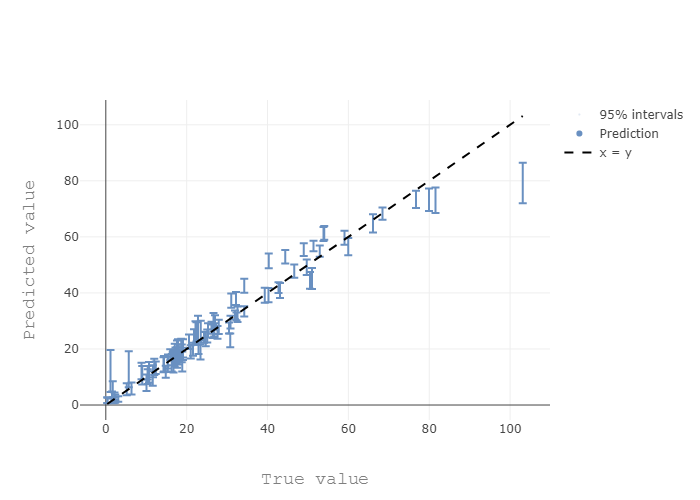

In [48]:
# Show plot as static image
Image(pio.to_image(fig, width=700, height=500, scale=1, format='png'))

#### Plot a 1D slice of the constrained model

In [44]:
# Plot constrained
mean, var, perc, mode, samples, times = model.calc_posterior_constrained(px_test_arr, compute_mode = False, num_samples = 1000, algorithm = 'minimax_tilting', resample = False)

p_lower = perc[0]
p_upper = perc[2]
p_label = '[p{}, p{}] conf.'.format(10, 90)

samplepaths_Z = []
if show_samplepaths: 
    samplepaths_Z = np.array(samples)

fig_constrained_slice = PlotGP2d(x_mean = px_test, mean = np.array(mean).flatten(),
                        samplepaths =  samplepaths_Z,
                        x_true = px_test, y_true = y_true,
                        p_lower = p_lower, p_upper = p_upper, p_label = p_label,
                        title = 'f(x) as a function of x[{0}] where x[i] = {1} for i != {0}'.format(plot_x_dim, x_base_val))

pltlyoff.iplot(fig_constrained_slice, filename='')

..Running calculation of K_w ... SKIP - (cached)
..Running calculation of Cholesky factor for K_w ... SKIP - (cached)
..Running preparation step 1 - dependence on (XS, X) ... DONE - time: 0.005 seconds
..Running preparation step 2 - dependence on (XV, X) ... SKIP - (cached)
..Running preparation step 3 - dependence on (XS, XV, X) ... DONE - time: 0.003 seconds
..sampling 1000 times from truncated constraint distribution C~|C, Y DONE - time: 0.089 seconds
..sampling 1000 times from constrained GP f*|C, Y DONE - time: 0.009 seconds
..computing statistics from samples DONE - time: 0.003 seconds
 DONE - Total time: 0.111 seconds


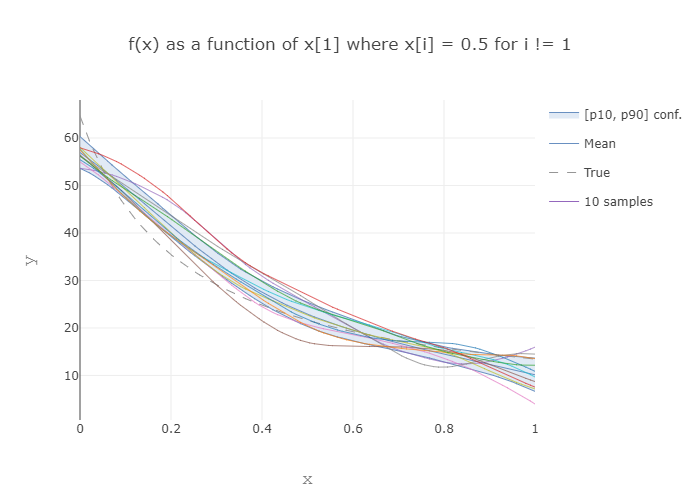

In [45]:
# Show plot as static image
Image(pio.to_image(fig_constrained_slice, width=700, height=500, scale=1, format='png'))